# Exercise Sheet 1 - CIFAR, MLP, Overfitting and Regularization



 * Deep Learning for Computer Vision – Winter Term 2024/25

 * Lecture by: Constantin Pape

 * Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair

 * Due date: **Tuesday, Nov 5, before 10:00**





## Time required to solve this exercise sheet

**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**





## Topic



In this exercise sheet, you will:

- get to know a new dataset: CIFAR-10

- implement a MLP

- get more familiar with model fitting

- see overfitting

- implement early stopping

- explore hyperparameters and their influence

- vary architecture to improve model performance



*We are looking forward to seeing your solutions! Have fun!*





## IMPORTANT SUBMISSION INSTRUCTIONS



- **You need to answer all questions in written form!**

- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`

- Only submit the Jupyter Notebook (.ipynb file). No other file is required.

    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 1`.

- Make only one submission of the exercise per group.

- The deadline is strict.

- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand



Implementation:

- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.



### How to work on the exercise?

You will need access to a machine with a GPU to properly work on the exercises. We recommend using [Kaggle](https://www.kaggle.com/), which offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are the initial steps to work the Kaggle Notebooks). You can load this notebook on kaggle via `File` -> `Import Notebook` -> `Browse Files` and `Import`

## Introduction



In this task you will build a multi layer perceptron (MLP) model with PyTorch and perform training and prediction on the CIFAR dataset.

## Tutorials



Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:

- [PyTorch tutorial](https://pytorch.org/tutorials/)

- [Seaborn tutorial](https://seaborn.pydata.org/tutorial.html)

## Imports



Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [61]:
import os

import time

import pathlib

import fastprogress



import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt



import torch

import torchvision

import torch.nn as nn

import torch.optim as optim

import torch.nn.functional as F

from torch.utils.data import DataLoader

### GPU and CUDA checks



Let's perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)

In [62]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.



Click the bottom-right corner menu `<` -> `Notebook options` -> `Accelerator` -> Select `GPU P100` as Hardware accelerator.



![image.png](attachment:image.png)



Now check the availability again (you would have to re-run the imports)

In [63]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

In [64]:
# DO NOT CHANGE

def get_device(cuda_preference=True):

    """Gets pytorch device object. If cuda_preference=True and 

        cuda is available on your system, returns a cuda device.

    

    Args:

        cuda_preference: bool, default True

            Set to true if you would like to get a cuda device

            

    Returns: pytorch device object

            Pytorch device

    """

    

    print(

        'cuda available:', torch.cuda.is_available(), 

        '; cudnn available:', torch.backends.cudnn.is_available(),

        '; num devices:', torch.cuda.device_count()

    )

    

    use_cuda = False if not cuda_preference else torch.cuda.is_available()

    device = torch.device('cuda:0' if use_cuda else 'cpu')

    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'

    print('Using device', device_name)

    return device

In [65]:
# DO NOT CHANGE

device = get_device()



# Get number of cpus to use for faster parallelized data loading

num_cpus = os.cpu_count()

print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla P100-PCIE-16GB
4 CPUs available


## Deep Learning with PyTorch



The process of training and evaluating a deep learning model begins with data loading. A dataset needs to be chosen on which the model should be trained. This data might need some preprocessing (like resizing or normalizing) of images. Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.



The next step is to **specify the model and its optimizer**, as well as the loss function. An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.



The model fitting is split into training and evaluation. In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction. The loss compares the prediction with the ground truth. In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step. In the evaluation process the loss is computed on the entire validation set. This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting. The model fitting process is repeated for N epochs which is another hyperparameter that needs to be chosen carefully.



After the training we evaluate the final model on the test set.



We'll go through the individual steps in the course of this notebook.



![image.png](attachment:image.png)

## Data Loading



## CIFAR dataset



This dataset contains natural images, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across it later to learn other concepts.



The first thing you should do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties. Feel free to visualize the images to have a better understanding.



**Download** the CIFAR dataset using torchvision dataset classes.

In [66]:
# DO NOT CHANGE

data_dir = pathlib.Path("data/")

cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

Files already downloaded and verified


Let's check the first sample to see what it looks like

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
<PIL.Image.Image image mode=RGB size=32x32 at 0x7EA269CD57B0>
6


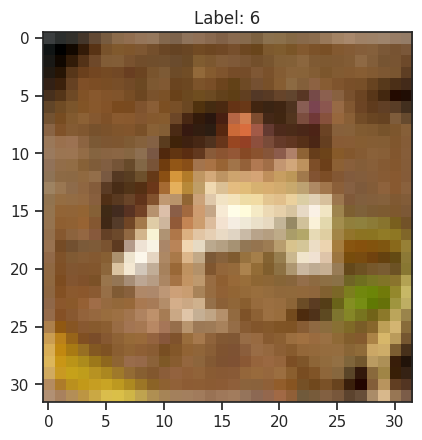

In [67]:

X_sample, y_sample = cifar[0]

print(cifar)

print(X_sample)
print(y_sample)

# TODO: display the label and the image
# Plot the image
plt.imshow(X_sample)
plt.title(f"Label: {y_sample}")
plt.show()

Look at the types of X and y.

In [68]:
# TODO: display types
print(type(X_sample))

print(type(y_sample))

<class 'PIL.Image.Image'>
<class 'int'>


How many data points are there in the dataset?

In [69]:
# TODO: print out the length of the dataset
print(len(cifar))

50000


## Loading data



### Preprocessing the Data



#### Transformation



We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, `pytorch` (the core library, not `torchvision`) is only equipped to work on Tensor objects. So we need to transform _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ to a torch tensor.



#### Normalization



Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance.



See https://pytorch.org/vision/stable/transforms.html for more information.



We can combine multiple transformations via _transforms.Compose_.

In [70]:
# DO NOT CHANGE

#download the CIFAR-10 dataset, compute its mean and standard deviation, and prepare normalized versions of the training and test datasets
def grab_data(data_dir, num_cpus=1):

    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 

        and standard deviation per channel of trainset, normalizes the train set

        accordingly.



    Args:

        data_dir (str): Directory to store data

        num_cpus (int, optional): Number of cpus that should be used to 

            preprocess data. Defaults to 1.



    Returns:

        CIFAR10, CIFAR10, float, float: Returns trainset and testset as

            torchvision CIFAR10 dataset objects. Returns mean and standard

            deviation used for normalization.

    """

    # pdwnload train images and convert to tensors (dataset consists of 50k training and 10k test images)
    # pixel values now of range [0, 1]
    trainset = torchvision.datasets.CIFAR10(

        data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor()

    )



    # Get normalization transform

    num_samples = trainset.data.shape[0]

    #load all the 50k train images as one batch
    trainloader = torch.utils.data.DataLoader(

        trainset, batch_size=num_samples, num_workers=num_cpus

    )

    # imgs contains all images, as there is only one batch
    # imgs tensor shape = (batch_size, num_channels, height, width) = 50000, RGB so 3, 32, 32 (because they are 32x32 pixel images)
    # so 50000 images, each of the 32x32 pixels with has RGB so 3 values
    imgs, _ = next(iter(trainloader))

    #dim = 0,2,3 -> batch size, height, width  -> excluding channel, i.e. dim=1, separate mean/sd for each RGB value instead of avg. over all 3
    dataset_mean = torch.mean(imgs, dim=(0,2,3))

    dataset_std = torch.std(imgs, dim=(0,2,3))



    normalized_transform = torchvision.transforms.Compose([

        torchvision.transforms.ToTensor(),

        torchvision.transforms.Normalize(dataset_mean, dataset_std)

    ])



    # Load again, now normalized

    trainset = torchvision.datasets.CIFAR10(

        data_dir, download=True, train=True, transform=normalized_transform

    )



    # Apply the same transform, computed from the train-set, to the test-set

    # so both have a similar distribution. We do not normalize the test-set directly,

    # since we are not allowed to perform any computations with it. (We only use it

    # for reporting results in the very end)

    testset = torchvision.datasets.CIFAR10(

        data_dir, download=True, train=False, transform=normalized_transform

    )



    return trainset, testset, dataset_mean, dataset_std

#### Training, Validation and Test Sets



For the correct ftting of a neural network, we need three dataset components: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data.



Note that you should not use the test set in any part of your training and model selection procedure. It should only be used for showing the final results.



We first need to **load** the datasets (above we did that already to calculate the normalization values. Then, we load them and **apply the normalization transform**)



We also need to **split** the train dataset into two sets, one for training and one for validation. While the training set needs to be quite large, the validation set can be relatively small. Take 10% of the dataset as validation set. Assign samples _randomly_ to the training and validation set, using a fixed seed to ensure reproducibility.

In [71]:
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):

    """Splits train dataset into train and validation dataset.



    Args:

        trainset (CIFAR10): CIFAR10 trainset object

        split_seed (int, optional): Seed used to randomly assign data

            points to the validation set. Defaults to 42.

        val_frac (float, optional): Fraction of training set that should be 

            split into validation set. Defaults to 0.2.



    Returns:

        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.

    """

    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)

    num_train_samples = trainset.data.shape[0] - num_val_samples

    trainset, valset = torch.utils.data.random_split(

        trainset, (num_train_samples, num_val_samples), generator=torch.Generator().manual_seed(split_seed)

    )

    return trainset, valset

To load the data for model training, we need to define **dataloaders**. A dataloader represents a Python iterable over a dataset and draws mini batches with random samples. Obseve below that we have a default number for batch size, and we shuffle the samples in batches.

In [72]:
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1):

    """Initialize train, validation and test data loader.



    Args:

        trainset (CIFAR10): Training set torchvision dataset object.

        valset (CIFAR10): Validation set torchvision dataset object.

        testset (CIFAR10): Test set torchvision dataset object.

        batch_size (int, optional): Batchsize that should be generated by 

            pytorch dataloader object. Defaults to 1024.

        num_cpus (int, optional): Number of CPUs to use when iterating over

            the data loader. More is faster. Defaults to 1.



    Returns:

        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects

            for training, validation and testing.(-1 * mean / std), (1.0 / std))
    res = denormalize(img)

    """

    trainloader = torch.utils.data.DataLoader(

        trainset, batch_size=batch_size, shuffle=True, num_workers=num_cpus

    )

    valloader = torch.utils.data.DataLoader(

        valset, batch_size=batch_size, shuffle=True, num_workers=num_cpus

    )

    testloader = torch.utils.data.DataLoader(

        testset, batch_size=batch_size, shuffle=True, num_workers=num_cpus

    )



    return trainloader, valloader, testloader

#### TODO

- Load the CIFAR 10 train and test data set using the functions defined above

- Generate a validation set from 20% of the training set samples. *Remember:* Keep the seed for the validation set generation fixed for reproducibility.

- Generate torch data loaders for the train, validation and test data set splits. Use a batch size of 1024.



*Hint:* we will use the mean and standard deviation returned by ```grab_data``` later

In [73]:
####################

## YOUR CODE HERE ##

####################

trainset, testset, dataset_mean, dataset_std= grab_data('data/')
trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader= init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=1)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Let's have a look at the dataset.



#### TODO

- Print all the class names

- Plot 16 images randomly drawn from the training set with their according class label



*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [74]:
import random
from torchvision.utils import make_grid

# Define CIFAR-10 classes
classes = trainset.dataset.classes
print("Class names:", classes)

def imshow(img, mean, std):

    """Undo normalization using mean and standard deviation and show image.



    Args:

        img (torch.Tensor): Image to show

        mean (np.array shape (3,)): Vector of means per channel used to

            normalize the dataset.

        std (np.array shape (3,)): Vector of standard deviations per channel 

            used to normalize the dataset.

    """

    # normalized f(value) = value - mean / sd
    # denormalize, ie back to value f^-1(normalized) =  (normalized * sd) + mean

    denormalize = torchvision.transforms.Normalize((-1 * mean / std), (1.0 / std))
    res = denormalize(img)

    res = torch.clamp(res, 0, 1)
    
    return(res)

    

# Define function to plot

# Plotting 16 randomly selected images from the training set
def plot_cifar_images(number_of_images, dataloader, dataset_mean, dataset_std):
    # Draw a batch of images from the dataloader
    images, labels = next(iter(dataloader))

    # Select a subset of images to plot
    images = images[:number_of_images]
    labels = labels[:number_of_images]

    # Undo normalization for each image
    images_denormalized = [imshow(img, dataset_mean, dataset_std) for img in images]

    # Create a grid of images
    grid = make_grid(images_denormalized, nrow=4)  # 4 images per row for a 4x4 grid

    # Plot the grid
    plt.figure(figsize=(12, 8))
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.title("Randomly Selected CIFAR-10 Images with Labels")
    plt.axis('off')
    plt.show()

    # Print class labels below the image
    print("Labels:")
    for i, label in enumerate(labels):
        print(f"Image {i + 1}: {classes[label]}")

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


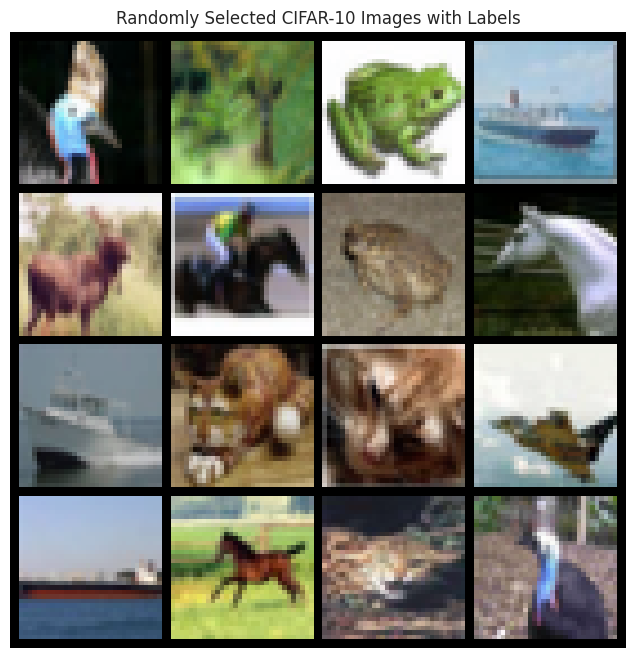

Labels:
Image 1: bird
Image 2: deer
Image 3: frog
Image 4: ship
Image 5: deer
Image 6: horse
Image 7: frog
Image 8: horse
Image 9: ship
Image 10: cat
Image 11: cat
Image 12: airplane
Image 13: ship
Image 14: horse
Image 15: cat
Image 16: bird


In [75]:
# Create actual plot and print the class names
plot_cifar_images(16, trainloader, dataset_mean, dataset_std)

Now that you know what CIFAR10 looks like, you can guess what the task for this dataset is: classification in natural images

## Training, evaluation and plotting functions



Here, we provide examples of training, evaluation and plotting functions. Some parts are still missing. You can ignore this for the time being and move to the next section "**MLP Model**". You will implement the missing parts of these functions when required in the next sections.

In [76]:
# loss =  measure of how well the model's predictions match the actual target values. It's a continuous value that indicates the cost associated with the model's predictions. => used during training to minimize, e.g. CrossEntropy
# Accuracy provides an intuitive measure of the model's performance, indicating the percentage of samples correctly classified
# loss = continous, any non negative value; accuracy: percentage, can be used to compare models, especially in classification tasks

def accuracy(correct, total): 

    """Compute accuracy as percentage.



    Args:

        correct (int): Number of samples correctly predicted.

        total (int): Total number of samples



    Returns:

        float: Accuracy

    """

    return float(correct)/total


# Epoch = one complete pass through entire training dataset: 
    # divide dataset into smaller batches
    # training step for each batch: forward passs (predictions and loss), backwards pass (compute gradients and update model parameters)
    # repeat, until all batches have been processed -> completed epoch


# Forward Pass: Compute predictions and loss.
# Backward Pass: Call loss.backward() to compute gradients.
# Update Parameters: Use an optimizer (e.g., Adam) to update model parameters based on these gradients.

def train(dataloader, optimizer, model, loss_fn, device, master_bar):

    """Run one training epoch.



    Args:

        dataloader (DataLoader): Torch DataLoader object to load data

        optimizer: Torch optimizer object

        model (nn.Module): Torch model to train

        loss_fn: Torch loss function

        device (torch.device): Torch device to use for training

        master_bar (fastprogress.master_bar): Will be iterated over for each

            epoch to draw batches and display training progress



    Returns:

        float, float: Mean loss of this epoch, fraction of correct predictions

            on training set (accuracy)

    """

    # loss for each batch, to compute mean loss later
    epoch_loss = []

    # epoch_correct = number of correct predictions, epoch_total = number of samples processed (increases after each batch iteration, not the same as batch size => total number of samples processed so far)
    epoch_correct, epoch_total = 0, 0


    # iterating over the batches
    # x = input data in a batch, with shape (batch_size, num_channels, height, width), e.g (1024, 3, 32, 32) for a batch size of 1024.
    # y = target labels for the input data in the batch, shape (batch_size,); Example: (1024,), where each element is an integer representing the class label (0-9 for CIFAR-10).
    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):

        #clear old gradients
        optimizer.zero_grad()
        #set model to training mode
        model.train()



        # Forward pass, computes the predictions
        
        y_pred = model(x.to(device))



        # For calculating the accuracy, save the number of correctly classified 

        # images and the total number
    
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))

        epoch_total += len(y)



        # Compute loss

        loss = loss_fn(y_pred, y.to(device))


        #Backprogagation = computing gradients (loss.backward()) + updating weights (optimizer.step())
        # Backward pass
        # automatic differentiation: Gradients get computed automatically via chain rule

        loss.backward()

        # update model parameters (weights) based on the gradients
        optimizer.step()



        # For plotting the train loss, save it for each sample

        epoch_loss.append(loss.item())



    # Return the mean loss and the accuracy of this epoch

    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)





def validate(dataloader, model, loss_fn, device, master_bar):

    """Compute loss, accuracy and confusion matrix on validation set.



    Args:

        dataloader (DataLoader): Torch DataLoader object to load data

        model (nn.Module): Torch model to train

        loss_fn: Torch loss function

        device (torch.device): Torch device to use for training

        master_bar (fastprogress.master_bar): Will be iterated over to draw 

            batches and show validation progress



    Returns:

        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 

            fraction of correct predictions on validation set (accuracy)

    """

    epoch_loss = []

    epoch_correct, epoch_total = 0, 0

    confusion_matrix = torch.zeros(10, 10)    # because there are 10 classes of images



    model.eval()

    # no gradients necessary during evaluation
    with torch.no_grad():

        
        #iterate over the batches
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):

            # make a prediction on validation set, ie a forward pass

            y_pred = model(x.to(device))



            # For calculating the accuracy, save the number of correctly 

            # classified images and the total number

            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))

            epoch_total += len(y)



            # Fill confusion matrix
            # y_pred.argmax(dim=1) -> select the class with the highest predicted probability for each sample
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):

                confusion_matrix[int(y_true), int(y_p)] +=1



            # Compute loss

            loss = loss_fn(y_pred, y.to(device))



            # For plotting the train loss, save it for each sample

            epoch_loss.append(loss.item())



    # Return the mean loss, the accuracy and the confusion matrix

    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


# early stopping: 
    # prevent overfitting during the training of machine learning models. It involves monitoring the model's performance on a validation set and stopping training when performance ceases to improve.
    # After each epoch, evaluate the model's performance on a separate validation dataset (validation and accuracy)
    # via patience parameter, which specifies how many epochs to wait for an improvement before stopping.
    # If no improvement is observed in the specified number of epochs, halt training
    # checkpoint: 
        # Save the model's state whenever an improvement is detected.
        # If training stops due to early stopping, revert to the best saved state.

# orchestrates the entire training process over multiple epochs, handling both training and validation phases, and integrates early stopping if specified
def run_training(

    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False

):

    """Run model training.



    Args:

        model (nn.Module): Torch model to train

        optimizer: Torch optimizer object

        loss_fn: Torch loss function for training

        device (torch.device): Torch device to use for training

        num_epochs (int): Max. number of epochs to train

        train_dataloader (DataLoader): Torch DataLoader object to load the

            training data

        val_dataloader (DataLoader): Torch DataLoader object to load the

            validation data

        early_stopper (EarlyStopper, optional): If passed, model will be trained

            with early stopping. Defaults to None.

        verbose (bool, optional): Print information about model training. 

            Defaults to False.



    Returns:

        list, list, list, list, torch.Tensor shape (10,10): Return list of train

            losses, validation losses, train accuracies, validation accuracies

            per epoch and the confusion matrix evaluated in the last epoch.

    """

    start_time = time.time()

    master_bar = fastprogress.master_bar(range(num_epochs))

    train_losses, val_losses, train_accs, val_accs = [],[],[],[]



    # iterate over each epoch
    for epoch in master_bar:

        # Train the model

        epoch_train_loss, epoch_train_acc = train(

            train_dataloader, optimizer, model, loss_function, device, master_bar

        )

        # Validate the model

        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(

            val_dataloader, model, loss_function, device, master_bar

        )



        # Save loss and acc for plotting

        train_losses.append(epoch_train_loss)

        val_losses.append(epoch_val_loss)

        train_accs.append(epoch_train_acc)

        val_accs.append(epoch_val_acc)

        

        if verbose:

            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

            

        if early_stopper:
            early_stopper.update(epoch_val_acc, model)
            if early_stopper.early_stop:
                if verbose:
                    master_bar.write("Early stopping triggered.")
                break



            # raise NotImplementedError # Comment out this keyword after your implementation



            # END OF YOUR CODE #

            

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)

    print(f'Finished training after {time_elapsed} seconds.')

    return train_losses, val_losses, train_accs, val_accs, confusion_matrix





def plot(

    title, label, train_results, val_results, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None

):

    """Plot learning curves.



    Args:

        title (str): Title of plot

        label (str): x-axis label

        train_results (list): Results vector of training of length of number

            of epochs trained. Could be loss or accuracy.

        val_results (list): Results vector of validation of length of number

            of epochs. Could be loss or accuracy.

        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 

            Defaults to 'linear'.

        save_path (str, optional): If passed, figure will be saved at this path.

            Defaults to None.

        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate

            of where an additional black dot will be plotted. Defaults to None.

        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.

    """

    

    epoch_array = np.arange(len(train_results)) + 1

    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()

    

    sns.set(style='ticks')



    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')

    legend = ['Train results', 'Validation results']

    

    if extra_pt:

        ####################

        ## YOUR CODE HERE ##

        ####################
        x_extra, y_extra = extra_pt
        plt.plot(x_extra, y_extra, c='black', marker='s', markersize = 10, label=extra_pt_label)
        legend.append(extra_pt_label)
        legend = ['Train results', 'Validation results', 'Highest Validation-Accuracy']
        

        #raise NotImplementedError # Comment out this keyword after your implementation



        # END OF YOUR CODE #

        

    plt.legend(legend)

    plt.xlabel('Epoch')

    plt.ylabel(label)

    plt.yscale(yscale)

    plt.title(title)

    

    sns.despine(trim=True, offset=5)

    plt.title(title, fontsize=15)

    if save_path:

        plt.savefig(str(save_path), bbox_inches='tight')

    plt.show()

## MLP model



#### TODO

- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings

- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs



*Hint*: As CIFAR 10 contains color images, amongst other dimensions you want to flatten the color channel dimension, too.

In [77]:
# MLP = Multilayer perceptron, basic neural network
# class MLP extends torch.nn.Module, base for all Neural Networks in Pytorch

# hidden units = neurons at the hidden layers, each hidden unit receives a combination of inputs from the previous layer, then passes the output forward to the next layer
# # hidden layer = layer of neurons between input and output in the neural net
# more hidden layers/units = more powerful the model is of capturing complex patterns

# linear hidden layer: y = Wx + b -> weighted sum + bias, but like this only capable of learning linear decision boundaries
# Activation function to learn non linear patterns

class MLP(nn.Module):

    """Multi layer perceptron torch model."""

    def __init__(

        self, img_width, num_in_channels, num_classes, num_hidden_units=30, num_hidden_layers=1, act_fn=None

    ):

        """Initialize model.



        Args:

            img_width (int): Width of images

            num_in_channels (int): Number of input channels of images

            num_classes (int): Number of classes to predict

            num_hidden_units (int, optional): Number of hidden units per layer. 

                Defaults to 30.

            num_hidden_layers (int, optional): Number of hidden layers. Total

                number of layers will be num_hidden_layers + 2. Defaults to 1.

            act_fn (nn activation function, optional): Activation function

                to use after the first and all the hidden layers. If None, use

                nn.ReLU(). Defaults to None.

        """

        input_dim = img_width * img_width * num_in_channels # total number of features in flattened input, img 32x32 pixels RGB = 3072
        output_dim = num_classes # 10 for CIFAR
        
        super(MLP, self).__init__()
        
        self.layers = nn.ModuleList() # store layers of MLP
        # The first layer is created with input_dim (3072 for CIFAR-10) as the input size and num_hidden_units as the output size. This is the input layer that connects the input features to the hidden units.
        self.layers.append(nn.Linear(input_dim, num_hidden_units))


        #add hidden layers 
        for k in range (num_hidden_layers-1):
            self.layers.append(nn.Linear(num_hidden_units, num_hidden_units))
            #after each hidden layer add activation function
            if act_fn is not None:
                self.layers.append(act_fn())
            else:
                self.layers.append(nn.ReLU())

        #output layer
        self.layers.append(nn.Linear(num_hidden_units, output_dim))
        



    
    # how the forward pass in this model works
    # expects 1D input
    def forward(self, x):

        """Compute model predictions.



        Args:

            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of

                batch of input images



        Returns:

            torch.Tensor, shape (batchsize, num_classes): Tensor of model

                predictions

        """
        # x.size(0) represents the batch size.
        # -1 means "infer the rest of the dimensions". In this case, it flattens each input image to a 1D vector of size 3072 (for 32x32x3)
        # This flattening is necessary because fully connected (nn.Linear) layers expect 1D input rather than 3D images
        # Better way of 
        x = x.view(x.size(0), -1)  
        
        for layer in self.layers:
            x = layer(x) # either do the linear transformation or activation function
        return x # SHape batch_size, num_classes -> so for each input image in the batch we get 10 logits(=probability of beloning to that class) for each class of images)

## Model training: learning rate



One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.



So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.



For optimization, we use the commonly used Adam optimizer (not SGD), since it behaves very robustly and is easy to use.



#### TODO:

- Instantiate a MLP model with one hidden layer and ReLU activation function 

- Train the model for 10 epochs

- Use the Adam optimizer

- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train

- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.



*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*



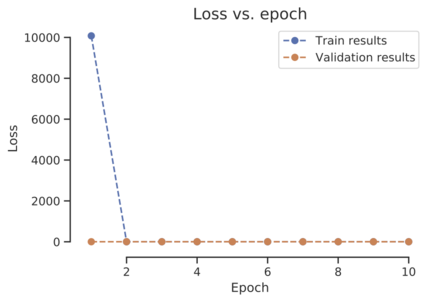



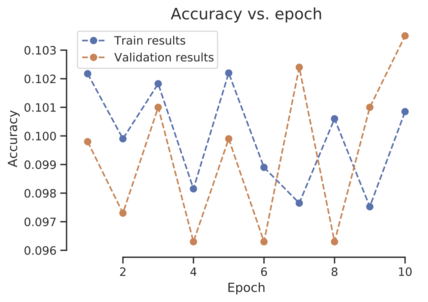

**This is an example of a model that does train:** *(Why?)*



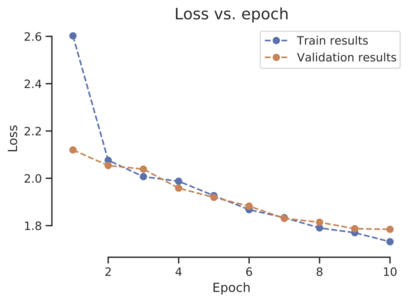



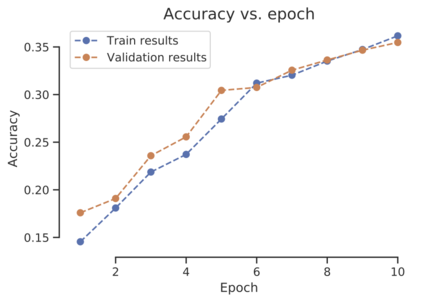

In [78]:
####################

## YOUR CODE HERE ##

####################

model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, act_fn=nn.ReLU).to(device)


learning_rates = [1.0, 0.1, 0.01, 0.001]
num_epochs = 10



# Create lists to store training curves for each learning rate
training_curves = []

# Loop over different learning rates
for lr in learning_rates:
    # Initialize the optimizer with the current learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Train the model and store the training curves
    train_losses, val_losses, train_accs, val_accs, _ = run_training(model, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader)
    
    training_curves.append((lr, train_losses, val_losses, train_accs, val_accs))

Finished training after 136 seconds.


Finished training after 138 seconds.


Finished training after 138 seconds.


Finished training after 139 seconds.


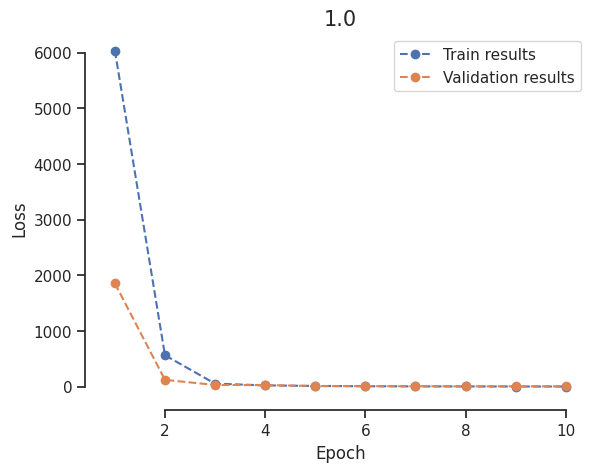

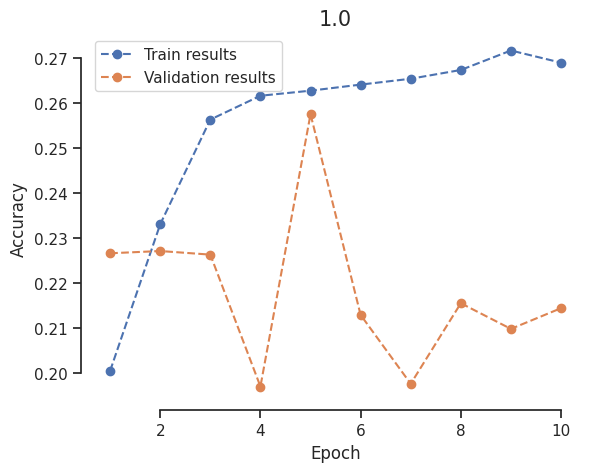

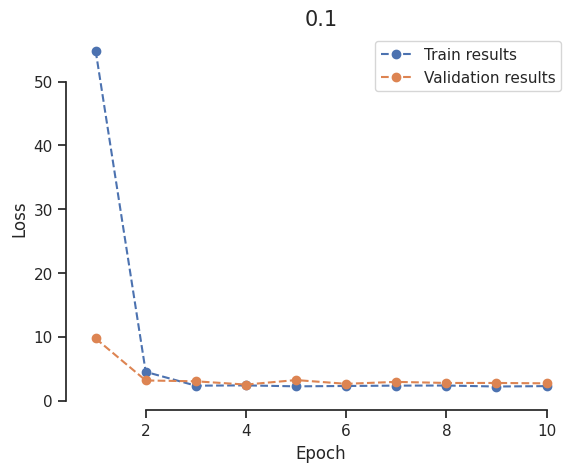

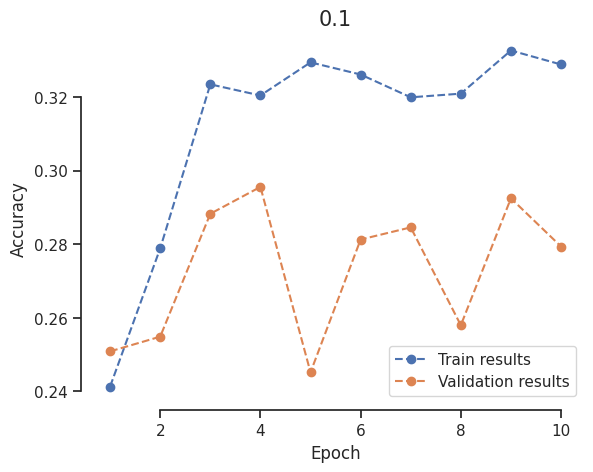

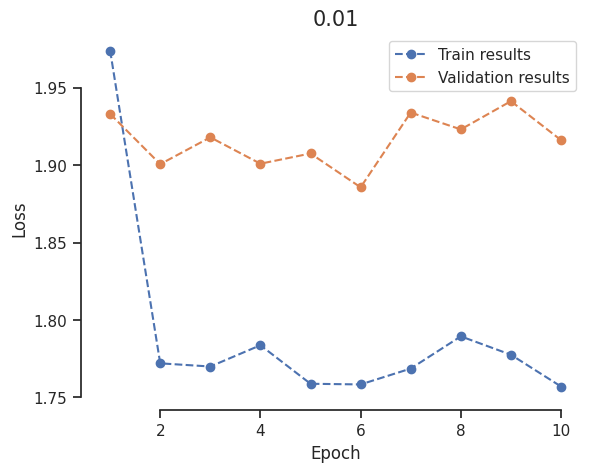

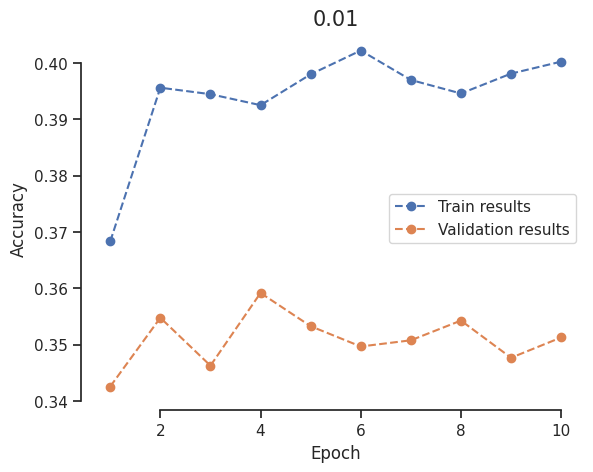

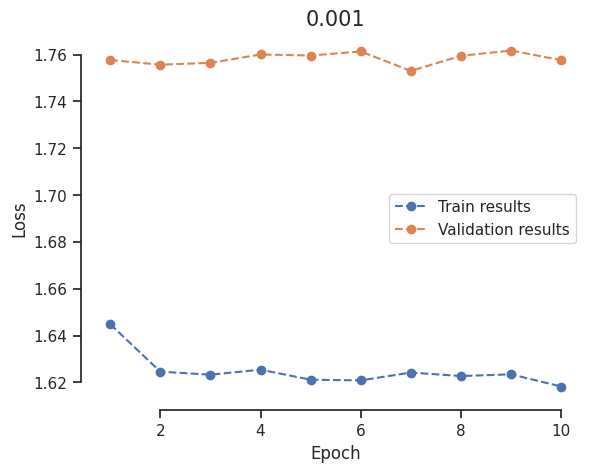

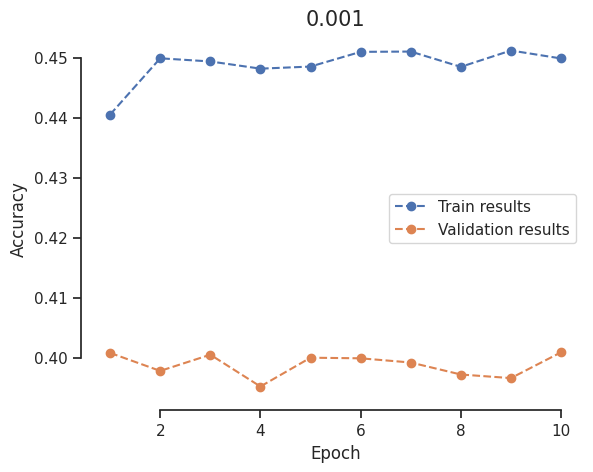

In [79]:
plot(training_curves[0][0], 'Loss', training_curves[0][1], training_curves[0][2])
plot(training_curves[0][0], 'Accuracy', training_curves[0][3], training_curves[0][4])

plot(training_curves[1][0], 'Loss', training_curves[1][1], training_curves[1][2])
plot(training_curves[1][0], 'Accuracy', training_curves[1][3], training_curves[1][4])

plot(training_curves[2][0], 'Loss', training_curves[2][1], training_curves[2][2])
plot(training_curves[2][0], 'Accuracy', training_curves[2][3], training_curves[2][4])

plot(training_curves[3][0], 'Loss', training_curves[3][1], training_curves[3][2])
plot(training_curves[3][0], 'Accuracy', training_curves[3][3], training_curves[3][4])

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your TODOs:



#### TODO:

- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)



#### TODO from now on, for all subsequent tasks:

- Print the overall best value and the epoch at which it occurred of:

    - val loss and

    - val accuracy

In [80]:
####################

## YOUR CODE HERE ##

####################

####################
## YOUR CODE HERE ##
####################

model_huge = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, act_fn=nn.ReLU).to(device)



num_epochs = 100


# Create lists to store training curves for each learning rate
training_curves = []

# Initialize the optimizer with the current learning rate
optimizer = optim.Adam(model_huge.parameters(), lr=0.01)
    
# Train the model and store the training curves
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_huge, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader)

Finished training after 1358 seconds.


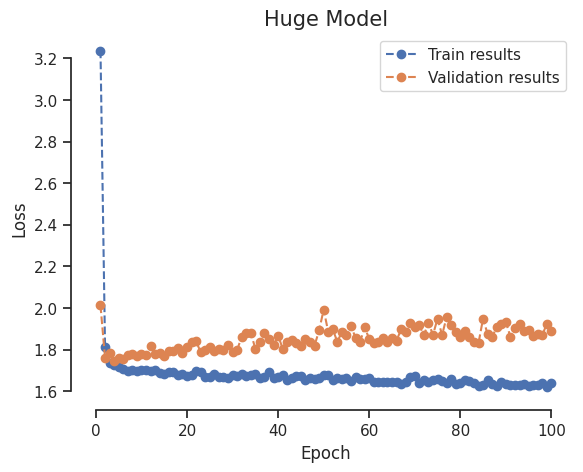

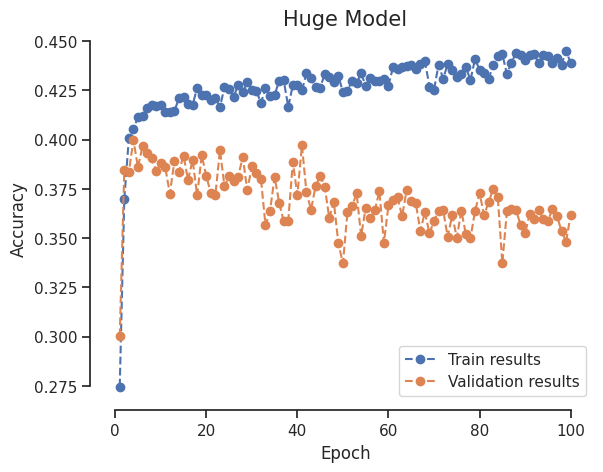

In [81]:
plot('Huge Model','Loss', train_losses, val_losses)
plot('Huge Model','Accuracy', train_accs, val_accs)

In [82]:
min_loss_train = min(train_losses)
min_loss_train_index = train_losses.index(min_loss_train)

print("Minimum loss training:", min_loss_train)
print("Index with the minimum loss training:", min_loss_train_index)

min_loss_val = min(val_losses)
min_loss_val_index = val_losses.index(min_loss_val)

print("Minimum loss validation:", min_loss_val)
print("Index with the minimum loss validation:", min_loss_val_index)

max_acc_val = max(val_accs)
max_acc_val_index = val_accs.index(max_acc_val)

print("Maximum accuracy validation:", max_acc_val)
print("Index with the maximum accuracy validation:", max_acc_val_index)

Minimum loss training: 1.6234492778778076
Index with the minimum loss training: 98
Minimum loss validation: 1.7458930969238282
Index with the minimum loss validation: 3
Maximum accuracy validation: 0.3998
Index with the maximum accuracy validation: 3


Let's have a look at those training curves! Here are some questions for you.



#### TODO:

Answer the following questions in written form, as they are really crucial for the rest of this course.



1. Does the training loss decrease after each epoch? Why does it? // Why does it not?

1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the minimum of the curves.)

1. Do the training and validation accuracy increase after each epoch? Why? // Why not?

1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?

1. (Optional): Do you have any ideas why not?

1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:

1. Based on the training curves, the training loss does only decrease only until Epoch 3. From that point on, it fluctuates and does not show a consistent decreasing trend. Explanation of this behavior are: 
- The optimizer might be reaching a plateau, where further improvements are difficult without adjustments, such as a lower learning rate.
- The model might be capturing noise or less relevant patterns in the training data, especially if training loss stops decreasing but remains relatively stable or fluctuates.

2. The validation loss decreases until Epoche 3 in the plots with the first two learn rates, suggesting this is the point where the model performs best on unseen data. But with a very small learn rate it begins to fluctuate after a few epochs. This fluctuation after the initial drop can be due to overfitting.

3. The training accuracy generally increases, as expected, since the model is optimizing its weights to fit the training data better. However, the validation accuracy reaches its peak around Epoch 3 and then stabilizes, with no further significant increase. This is a typical sign that the model’s ability to generalize to new data has plateaued, possibly due to overfitting if additional epochs only improve training accuracy without further improving validation accuracy.

4. No, the epochs with the best validation loss (Epoch 3) and best validation accuracy (later Epoches) are not the same. 

6. The model performed best at Epoch 3, where the validation loss was at its minimum. This is likely the optimal model state for generalization, meaning it would be the best choice for predicting on the test set. Saving the model at this point avoids overfitting, ensuring it performs well on unseen data.

## Save and restore model checkpoints



Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!



#### TODO:

- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk

- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.

- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.

- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.

- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.



*Hints:*

- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html

- Use `model.state_dict()`

In [83]:
####################

## YOUR CODE HERE ##

####################


checkpoint = {
    'state_dict': model_huge.state_dict(),
    'optimizer': optimizer.state_dict()
}

torch.save(checkpoint, 'checkpoint.pth')
print("Checkpoint saved successfully.")

Checkpoint saved successfully.


In [84]:
# 2. Initialize a new model with the same architecture
model2 = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, act_fn=nn.ReLU).to(device)

# 3. Compute validation accuracy before loading checkpoint
validation_acc_before = validate(valloader, model2, nn.CrossEntropyLoss(), device=device, master_bar=None)[1]
print(f"Validation Accuracy before loading checkpoint: {validation_acc_before:.4f}")


Validation Accuracy before loading checkpoint: 0.1095


In [85]:
# 4. Load the checkpoint into model2
checkpoint = torch.load('checkpoint.pth')
model2.load_state_dict(checkpoint['state_dict'])
model2.eval()
print("Checkpoint loaded into model2.")

# 5. Compute validation accuracy after loading checkpoint
validation_acc_after = validate(valloader, model2, nn.CrossEntropyLoss(), device=device, master_bar=None)[1]
print(f"Validation Accuracy after loading checkpoint: {validation_acc_after:.4f}")

Checkpoint loaded into model2.


/tmp/ipykernel_30/403066192.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint.pth')


Validation Accuracy after loading checkpoint: 0.3618


In [87]:
# Compute validation accuracy of model_huge
validation_acc_huge = validate(
    dataloader=valloader,
    model=model_huge,
    loss_fn=nn.CrossEntropyLoss(),
    device=device,
    master_bar=None
)[1]  # [1] corresponds to accuracy

print(f"Validation Accuracy of model_huge: {validation_acc_huge:.4f}")


Validation Accuracy of model_huge: 0.3618


## Early Stopping



So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.





#### TODO:

- Implement the `EarlyStopper` class below

- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [88]:
class EarlyStopper:

    """Early stops the training if validation accuracy does not increase after a

    given patience. Saves and loads model checkpoints.

    """

    def __init__(self, verbose=False, path='checkpoint.pt', patience=1):

        """Initialization.



        Args:

            verbose (bool, optional): Print additional information. Defaults to False.

            path (str, optional): Path where checkpoints should be saved. 

                Defaults to 'checkpoint.pt'.

            patience (int, optional): Number of epochs to wait for increasing

                accuracy. If accuracy does not increase, stop training early. 

                Defaults to 1.

        """

        ####################

        ## YOUR CODE HERE ##

        ####################
        self.verbose = verbose
        self.path = path # file path to save the model checkpoint(=model state whenever an improvement is detected)
        self.patience = patience # number of consecutive epochs without improvement after which training should stop 
        self.counter = 0 # Tracks the number of consecutive epochs without improvement.
        self.best_val_acc = None # Stores the best validation accuracy observed so far.
        self._early_stop = False # A boolean flag indicating whether early stopping has been triggered.



    @property #Provides read-only access to self._early_stop
    #@property decorator to allow early_stop to be accessed like an attribute.

    def early_stop(self):

        """True if early stopping criterion is reached.



        Returns:

            [bool]: True if early stopping criterion is reached.

        """

        return self._early_stop


    # update the EarlyStopper with the latest validation accuracy and determine whether to trigger early stopping.
    def update(self, val_acc, model):

        """Call after each epoch of model training to update early stopper object.



        Args:

            val_acc (float): Accuracy on validation set

            model (nn.Module): torch model that is trained

        """

        if self.best_val_acc is None or val_acc > self.best_val_acc:
            # If this is the best accuracy so far, save the checkpoint, reset counter to 0
            self.best_val_acc = val_acc
            self.counter = 0
            self.save_checkpoint(model, val_acc)
        else:
            # If accuracy did not improve, increment the counter
            self.counter += 1
            if self.verbose:
                print(f"Validation accuracy did not improve. Patience counter: {self.counter}")
            if self.counter >= self.patience:
                # If the patience limit is reached, trigger early stopping
                self._early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")


    # Save the model's state dictionary to the specified path
    def save_checkpoint(self, model, val_acc):

        """Save model checkpoint.



        Args:

            model (nn.Module): Model of which parameters should be saved.

        """

        torch.save({
            'model_state_dict': model.state_dict(),
            'val_acc': val_acc
        }, self.path)
        if self.verbose:
            print(f"Validation accuracy improved to {val_acc:.4f}. Model checkpoint saved to {self.path}.")



    # Load the model's state dictionary from the specified path.
    def load_checkpoint(self, model):

        """Load model from checkpoint.



        Args:

            model (nn.Module): Model that should be reset to parameters loaded

                from checkpoint.



        Returns:

            nn.Module: Model with parameters from checkpoint

        """

        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        if self.verbose:
            print(f"Loaded model from checkpoint at {self.path} with validation accuracy: {checkpoint['val_acc']:.4f}")
        return model

#### TODO:

- Train a MLP model (same architecture, optimization, etc. as you used before)

- Set `num_epochs = 100`

- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)



#### TODO here and for all subsequent exercises:

- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

In [89]:
####################

## YOUR CODE HERE ##

####################
model_stop = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, act_fn=nn.ReLU).to(device)

stopper = EarlyStopper()


num_epochs = 100

# Initialize the optimizer with the current learning rate
optimizer = optim.Adam(model_stop.parameters(), lr=0.01)
    
# Train the model and store the training curves
train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_stop, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper = stopper)

Finished training after 38 seconds.


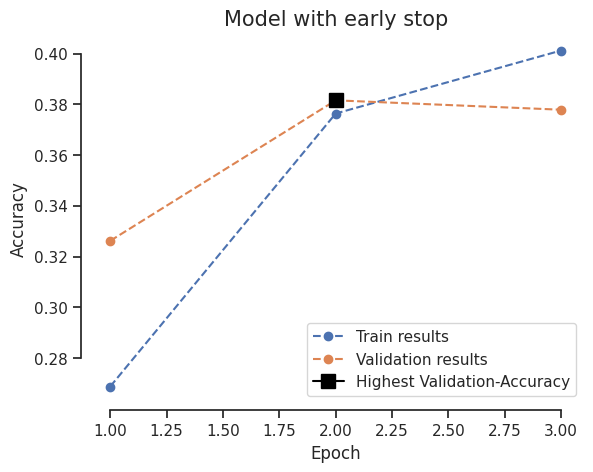

In [90]:
max_acc_val = max(val_accs)
max_acc_val_index = val_accs.index(max_acc_val)
plot('Model with early stop','Accuracy', train_accs,  val_accs, extra_pt = (max_acc_val_index+1,max_acc_val))

#### TODO:

- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?

- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.

- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

In [91]:
####################

## YOUR CODE HERE ##

####################


patience_values = [1,3,5]

model_patience = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, act_fn=nn.ReLU).to(device)


num_epochs = 100

optimizer = optim.Adam(model_patience.parameters(), lr=0.01)


training_patience = []


for value in patience_values:
    print(value)
    stopper = EarlyStopper(patience=value)
    
    # Train the model and store the training curves
    train_losses, val_losses, train_accs, val_accs, _ = run_training(model_patience, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = True)
    
    training_patience.append((value,train_losses, val_losses, train_accs, val_accs))

1


Finished training after 55 seconds.
3


Finished training after 109 seconds.
5


Finished training after 110 seconds.


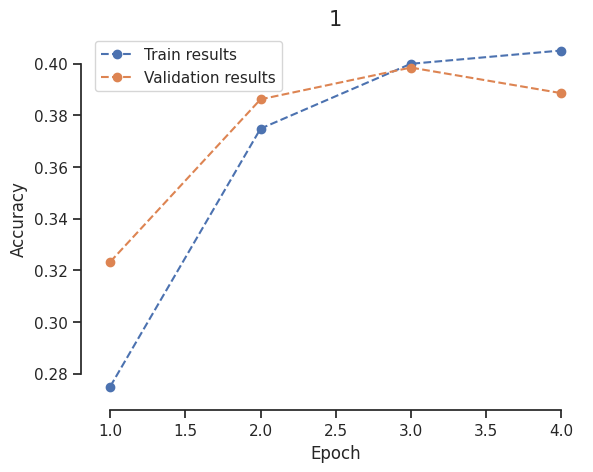

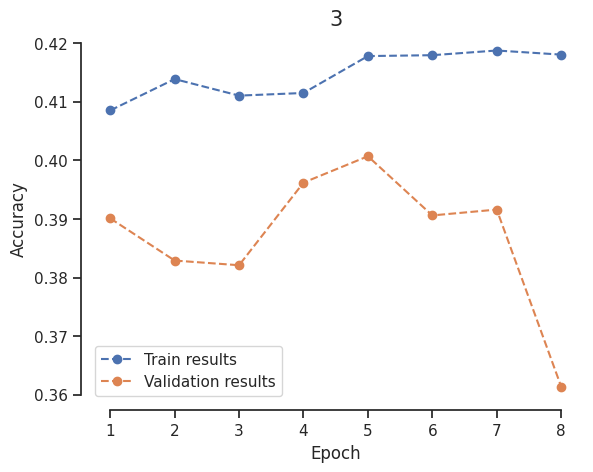

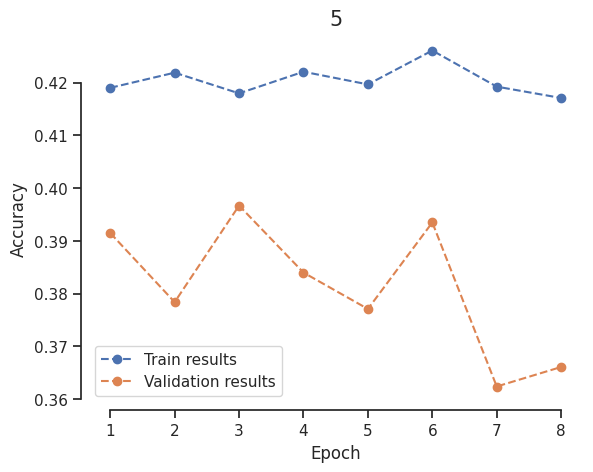

In [92]:

plot(training_patience[0][0], 'Accuracy', training_patience[0][3], training_patience[0][4])


plot(training_patience[1][0], 'Accuracy', training_patience[1][3], training_patience[1][4])


plot(training_patience[2][0], 'Accuracy', training_patience[2][3], training_patience[2][4])

## Which learning rate is best?



Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.



#### TODO:

- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`

- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`

- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

In [93]:
lr = 1e-3



####################

## YOUR CODE HERE ##

####################

model_lr = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, act_fn=nn.ReLU).to(device)

stopper = EarlyStopper()

num_epochs = 100

optimizer = optim.Adam(model_lr.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_lr, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = True)

Finished training after 43 seconds.


In [94]:
lr = 1e-4



####################

## YOUR CODE HERE ##

####################

model_tiny = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, act_fn=nn.ReLU).to(device)

stopper = EarlyStopper()

num_epochs = 100

optimizer = optim.Adam(model_tiny.parameters(), lr=lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_tiny, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = True)

Finished training after 193 seconds.


# What about the architecture?



How does architecture affect predictive performance? 



#### TODO:

In the following, try to improve model performance by varying 

- number of  hidden units

- number of layers



These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 



Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

In [95]:
# number of hidden units



####################

## YOUR CODE HERE ##

####################

hidden_units = [20,30,40]
num_epochs = 100
accuracies_units = []

for unit in hidden_units:

    model_hidden_units = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1, num_hidden_units=unit, act_fn=nn.ReLU).to(device)

    stopper = EarlyStopper()

    optimizer = optim.Adam(model_hidden_units.parameters(), lr=1e-3)

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_hidden_units, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = True)
    accuracies_units.append(val_accs)
    
print(accuracies_units)

Finished training after 27 seconds.


Finished training after 69 seconds.


Finished training after 97 seconds.
[[0.3767, 0.3764], [0.3799, 0.39, 0.3916, 0.393, 0.3857], [0.3865, 0.3871, 0.3968, 0.3989, 0.3995, 0.4106, 0.4023]]


In [96]:
# number of layers



####################

## YOUR CODE HERE ##

####################

hidden_layers = [2,3,4]
num_epochs = 100
accuracies_layers = []

for layer in hidden_layers:

    model_hidden_layers = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=layer,act_fn=nn.ReLU).to(device)

    stopper = EarlyStopper()

    optimizer = optim.Adam(model_hidden_layers.parameters(), lr=1e-3)

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_hidden_layers, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = True)
    accuracies_units.append(val_accs)

Finished training after 96 seconds.


Finished training after 126 seconds.


Finished training after 110 seconds.


In [97]:
# activation function
activation_functions = [nn.ELU, nn.ReLU, nn.Sigmoid]
num_epochs = 100
accuracies_functions = []

for function in activation_functions:

    model_functions = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=1,act_fn=function).to(device)

    stopper = EarlyStopper()

    optimizer = optim.Adam(model_functions.parameters(), lr=1e-3)

    train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(model_functions, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = True)
    accuracies_functions.append(val_accs)

Finished training after 56 seconds.


Finished training after 99 seconds.


Finished training after 42 seconds.


#### Questions

- How good do you get?

- Which hyper-parameter makes the largest difference?

- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?

**Your answers:**

- ...

Now, here are more TODO's, questions and a little challenge for you: 



#### TODO:

- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?

- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?

    - When creating the exercise, I got a validation accuracy of 57%

    - Surpassing 50% val. acc. should be possible for you

In [98]:
# Your best model:



####################

## YOUR CODE HERE ##

####################

best_model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=2, num_hidden_units= 20, act_fn=nn.ReLU).to(device)

stopper = EarlyStopper(patience=10)

optimizer = optim.Adam(best_model.parameters(), lr=1e-3)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = run_training(best_model, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = True)
    
print(val_accs)

Finished training after 566 seconds.
[0.3534, 0.3894, 0.4043, 0.4174, 0.4178, 0.4302, 0.436, 0.4367, 0.4425, 0.4434, 0.4445, 0.4406, 0.4468, 0.4523, 0.4518, 0.4533, 0.454, 0.4568, 0.4568, 0.456, 0.4532, 0.4535, 0.4528, 0.4601, 0.453, 0.4603, 0.4591, 0.4564, 0.4609, 0.4618, 0.4624, 0.4605, 0.4578, 0.4603, 0.4586, 0.4578, 0.4578, 0.458, 0.4579, 0.4617, 0.4583]


In [99]:
best_model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_layers=2, num_hidden_units= 20, act_fn=nn.ReLU).to(device)

stopper = EarlyStopper(patience=10)

optimizer = optim.Adam(best_model.parameters(), lr=1e-3)

train_losses, val_losses, train_accs, val_accs2, confusion_matrix = run_training(best_model, optimizer, 
                                                                   nn.CrossEntropyLoss(), device, 
                                                                   num_epochs, trainloader, valloader, early_stopper=stopper, verbose = True)
    
print(val_accs2)

Finished training after 526 seconds.
[0.369, 0.3967, 0.408, 0.4184, 0.4251, 0.4278, 0.4329, 0.4281, 0.4389, 0.4389, 0.436, 0.4481, 0.4428, 0.4467, 0.4492, 0.4508, 0.4498, 0.4516, 0.4476, 0.4534, 0.4558, 0.4505, 0.4552, 0.4581, 0.4604, 0.4572, 0.4526, 0.4562, 0.4587, 0.4643, 0.4555, 0.4573, 0.4586, 0.4598, 0.4602, 0.4567, 0.4578, 0.4621, 0.4621, 0.4605]


#### Questions:

- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?

- What could we do about this?

    - *Hint:* there are actually multiple answers to this question. 

    - One could be to change model training and evaluation. How?

    - The other could be to use a more sophisticated analysis. How?

# Evaluate your best model on test set, once!



When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.



#### TODO:

- What is the accuracy of the best model you found on the test set?

- Plot the confusion matrix, too!

In [100]:
def test(test_loader, model, device):

    """Compute accuracy and confusion matrix on test set.



    Args:

        test_loader (DataLoader): torch DataLoader of test set

        model (nn.Module): Model to evaluate on test set

        device (torch.device): Device to use



    Returns:

        float, torch.Tensor shape (10,10): Returns model accuracy on test set

            (percent classified correctly) and confusion matrix

    """

    ####################

    ## YOUR CODE HERE ##

    ####################

    model.eval()
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)

    with torch.no_grad():
        for  x, y in test_loader:
            # Make predictions on the test set
            y_pred = model(x.to(device))

            # For calculating accuracy, save the number of correctly classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill the confusion matrix
            for (y_true, y_pred) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_pred)] += 1

    # Calculate accuracy
    acc = accuracy(epoch_correct, epoch_total)

    return acc, confusion_matrix

*Hint:* Use sklearn to create the confusion matrix ([link](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html))

In [101]:
# The accuracy and confusion matrix



####################

## YOUR CODE HERE ##

####################

accuracy_test, confusion_matrix_tes = test(testloader, best_model, device)

print(accuracy_test)

0.4515


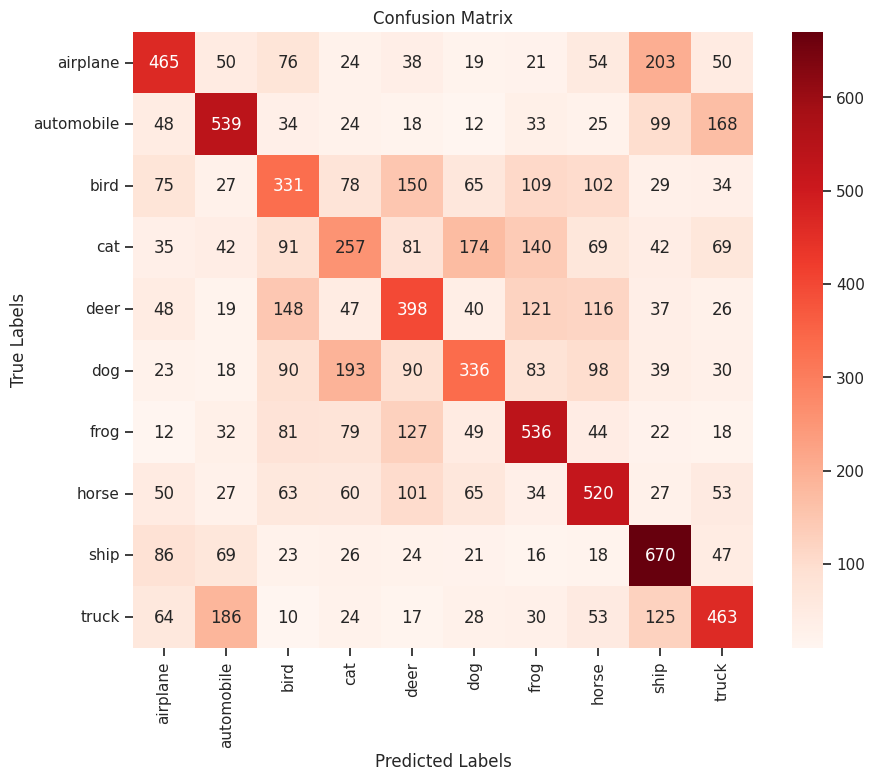

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

def calc_confusion_values_absolute(dataloader, model, device):
    """Method to compute the confusion values on the validation set"""
    
    # Set the model to evaluation mode
    model.eval()  

    y_true = [] 
    y_pred = [] 

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over the batches in the dataloader
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass: compute the predicted outputs of the model
            outputs = model(inputs)

            # Obtain the predicted class indices by finding the maximum value along the output's dimension 1
            _, predicted = torch.max(outputs, dim=1)

            # Extend the lists of true labels and predicted labels with the current batch's values
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(predicted.cpu().numpy().tolist())

    # Compute the confusion matrix using scikit-learn's confusion_matrix function
    confusion = sklearn.metrics.confusion_matrix(y_true, y_pred)
    

    return confusion 



# Calculate the confusion matrix
confusion_matrix = calc_confusion_values_absolute(testloader, best_model, device)

# Define class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Questions:

- On which classes is your model's prediction poor?

- Is the test accuracy of your model as good as the validation accuracy?

- If those values are different: How can you explain the difference?

- Why should you never use test set performance when trying out different hyper-parameters and architectures?

## How about the optimizer? _(Optional)_



_This task is optional, you do not need to solve it_



Now let's check out what difference it makes to use different optimizers in the learning strategy and what effect it has on the performance.



#### TODO *(Optional)*:



- Run training of the same model used above with

    - different optimizers (_hint_ - https://pytorch.org/docs/stable/optim.html)

- Compare your training results of all the different optimizer settings from above.

- What is your observation while using different optimizers? What is the respective impact on the model performance?

In [ ]:
###############################

## YOUR CODE HERE - OPTIONAL ##

###############################

## Explore batch size *(Optional)*



*This task is optional, you do not need to solve it*



Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.





#### TODO *(Optional)*:

- Run training of the same model used above with 

    - batch size 1 for **one epoch**

    - batch size 512 for 100 epochs, using early stopping with patience 10

- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)

- Was it smart to set batch size to 1?

- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)

- What is the impact on model performance?



*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [ ]:
# Batch size 1



###############################

## YOUR CODE HERE - OPTIONAL ##

###############################

In [ ]:
# Batch size 512



###############################

## YOUR CODE HERE - OPTIONAL ##

###############################

(OPTIONAL) You should evaluate on the test set with the optional solutions here (and see if they lead to performance gain).



In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials. You don't need to present the optional exercises

## Explore Activation Function _(Optional)_



*This task is optional, you do not need to solve it*



### TODO _(Optional)_:



Let's change activation function used (e.g. see [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity))

- Run training of the same model used above with a new activation function 

- Compare your training results

In [ ]:
###############################

## YOUR CODE HERE - OPTIONAL ##

###############################